<a href="https://colab.research.google.com/github/sutharimanikanta/-technity-tasks-/blob/main/project_food_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!pip install  -U -q -tf nightly
import tensorflow as tf
print(f"version{tf.__version__}")
import datetime
print(datetime.datetime.now())

version2.15.0
2023-12-24 05:13:58.649121


In [29]:
import os
if not  os.path.exists("helper_functions.py"):
   !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
else:
  print("not fund")

not fund


In [30]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [31]:
import tensorflow_datasets as tfds


In [33]:
datasets_list=tfds.list_builders()
target="food101"
print(f"'{target}' in tensorfloe data {target in datasets_list}")

'food101' in tensorfloe data True


In [34]:
(train_data,test_data),ds_info=tfds.load(name="food101",
                                        split=["train","validation"],
                                        shuffle_files=True,
                                        as_supervised=True,
                                        with_info=True,
                                        )

In [35]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [36]:
class_name=ds_info.features["label"].names
print(class_name[:10])


['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito']


In [37]:
train_one=train_data.take(1)

In [38]:
train_one

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [39]:
for image,label in train_one:
  print(f"""
  image shape{image.shape},
  image dtypes{image.dtype},
  Target class from Food101 (tensor ):{label}
  class name (str form): {class_name[label.numpy()]}""")


  image shape(512, 289, 3),
  image dtypes<dtype: 'uint8'>,
  Target class from Food101 (tensor ):45
  class name (str form): frozen_yogurt


In [40]:
tf.reduce_min(image),tf.reduce_max(image)

(<tf.Tensor: shape=(), dtype=uint8, numpy=0>,
 <tf.Tensor: shape=(), dtype=uint8, numpy=255>)

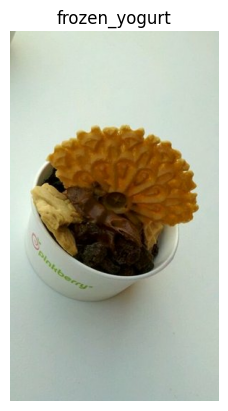

In [41]:
import matplotlib.pyplot as plt
plt.imshow(image)
plt.title(class_name[label.numpy()])
plt.axis(False);

In [42]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
    """
    Converts image datatype from 'uint8' -> 'float32' and reshapes image to
    [img_shape, img_shape, color_channels]
    """
    image = tf.image.resize(image, [img_shape, img_shape]) # reshape to img_shape
    return tf.cast(image, tf.float32), label #

In [43]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
print(f"Image before preprocessing:\n {image[:2]}...,\nShape: {image.shape},\nDatatype: {image.dtype}\n")
print(f"Image after preprocessing:\n {preprocessed_img[:2]}...,\nShape: {preprocessed_img.shape},\nDatatype: {preprocessed_img.dtype}\n\n")

Image before preprocessing:
 [[[145 151 125]
  [157 163 137]
  [159 165 139]
  ...
  [197 209 199]
  [197 209 199]
  [197 207 198]]

 [[146 152 126]
  [156 162 136]
  [158 164 138]
  ...
  [197 209 199]
  [197 209 199]
  [199 209 200]]]...,
Shape: (512, 289, 3),
Datatype: <dtype: 'uint8'>

Image after preprocessing:
 [[[147.19739 153.19739 127.19739]
  [157.22768 163.22768 137.22768]
  [158.09805 164.09805 138.09805]
  ...
  [197.      209.      197.54907]
  [197.      209.      199.     ]
  [198.09914 208.38936 199.24425]]

 [[154.69467 160.69467 134.69467]
  [155.87053 161.87053 135.87053]
  [158.39908 164.39908 138.39908]
  ...
  [197.      209.      197.54907]
  [197.      209.      199.     ]
  [196.32831 206.61853 195.76364]]]...,
Shape: (224, 224, 3),
Datatype: <dtype: 'float32'>




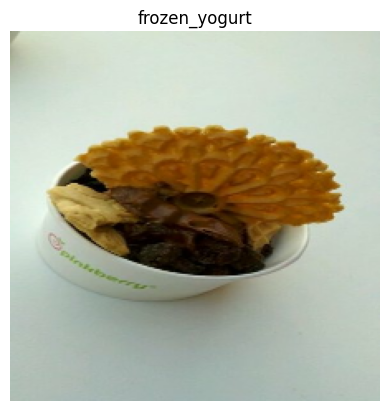

In [44]:
# We can still plot our preprocessed image as long as we
# divide by 255 (for matplotlib capatibility)
plt.imshow(preprocessed_img/255.)
plt.title(class_name[label])
plt.axis(False);

In [45]:
train_data=train_data.map(map_func=preprocess_img,num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [46]:
train_data,test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [47]:
# Create TensorBoard callback (already have "create_tensorboard_callback()" from a previous notebook)
from helper_functions import create_tensorboard_callback

# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don

In [48]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global

In [49]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [50]:
from tensorflow.keras import layers
input_shape=(224,224,3)
base_model=tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_name))(x) # want one output neuron per class
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [51]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [52]:
for layer in model.layers:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [53]:
for layer in model.layers[1].layers[:20]:
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_2 False float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float

In [54]:
tf.get_logger().setLevel('ERROR')
# Fit the model with callbacks
history_101_food_classes_feature_extract = model.fit(train_data,
                                                     epochs=3,
                                                     steps_per_epoch=len(train_data),
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                    callbacks=[create_tensorboard_callback("training_logs",
                                                                                            "efficientnetb0_101_classes_all_data_feature_extract"),
                                                                model_checkpoint])

Saving TensorBoard log files to: training_logs/efficientnetb0_101_classes_all_data_feature_extract/20231224-051620
Epoch 1/3
2368/2368 [==============================] - 209s 84ms/step - loss: 1.7191 - accuracy: 0.5822 - val_loss: 1.1312 - val_accuracy: 0.6944
Epoch 2/3
2368/2368 [==============================] - 224s 93ms/step - loss: 1.2007 - accuracy: 0.6894 - val_loss: 1.0238 - val_accuracy: 0.7211
Epoch 3/3
2368/2368 [==============================] - 222s 93ms/step - loss: 1.0545 - accuracy: 0.7246 - val_loss: 0.9961 - val_accuracy: 0.7233


In [55]:
results_feature=model.evaluate(test_data)
results_feature

790/790 [==============================] - 62s 79ms/step - loss: 0.9977 - accuracy: 0.7277


[0.9976838827133179, 0.7277227640151978]

In [58]:
def create_model():
    input_shape=(224,224,3)
    base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
    base_model.trainable=False
    inputs=layers.Input(shape=input_shape,name="input_layer")
    x=base_model(inputs,training=False)#weights of the corresponding layers will not be updated during the training process.
    x=layers.GlobalAveragePooling2D(name="pooling_layer")(x)# name artibute  only for human readable form
    x=layers.Dense(len(class_name))(x)
    outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x)
    model = tf.keras.Model(inputs, outputs)

    return model

# 2. Create and compile a new version of the original model (new weights)
created_model = create_model()
created_model.compile(loss="sparse_categorical_crossentropy",
                      optimizer=tf.keras.optimizers.Adam(),
                      metrics=["accuracy"])

# 3. Load the saved weights
created_model.load_weights(checkpoint_path)

# 4. Evaluate the model with loaded weights
results_created_model_with_loaded_weights = created_model.evaluate(test_data)


790/790 [==============================] - 70s 85ms/step - loss: 0.9977 - accuracy: 0.7277


In [60]:
# 5. Loaded checkpoint weights should return very similar results to checkpoint weights prior to saving
import numpy as np
assert np.isclose(results_feature, results_created_model_with_loaded_weights).all(), "Loaded weights results are not close to original model."  # check if all elements in array are close

In [61]:
# Check the layers in the base model and see what dtype policy they're using
for layer in created_model.layers[1].layers[:20]: # check only the first 20 layers to save printing space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_3 False float32 <Policy "float32">
rescaling_4 False float32 <Policy "mixed_float16">
normalization_2 False float32 <Policy "mixed_float16">
rescaling_5 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float

* Save the whole model to file

In [62]:
# saveing model to google Drive
# cteate save path to drive
#save_dir="/content/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision/"
## os.makedirs(save_dir)#Make directory if it doesn,t exist
## save model
# model.save(save_dir)

* Cloning the model preserve dtypes policy but not data weights

In [63]:
# for saving model in dirct googe colab
save_dir="07_efficientnetb0_feature_extract_model_mixed_precision"
model.save(save_dir)

In [64]:
loaded_saved_model=tf.keras.models.load_model(save_dir)


In [65]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_saved_model.layers[1].layers[:20]: # check only the first 20 layers to save output space
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float3

In [66]:
# Check loaded model performance (this should be the same as results_feature_extract_model)
results_loaded_saved_model = loaded_saved_model.evaluate(test_data)
results_loaded_saved_model

790/790 [==============================] - 58s 69ms/step - loss: 0.9977 - accuracy: 0.7277


[0.9976840019226074, 0.7277227640151978]

In [67]:
# The loaded model's results should equal (or at least be very close) to the model's results prior to saving
# Note: this will only work if you've instatiated results variables
import numpy as np
assert np.isclose(results_feature, results_loaded_saved_model).all()
# assert for exceptions

## preparing our model layers for fine tuning

In [69]:
loaded_gs_model=tf.keras.models.load_model("/content/07_efficientnetb0_feature_extract_model_mixed_precision")

In [70]:
loaded_gs_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense_1 (Dense)             (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                           

In [71]:
# How does the loaded model perform?
results_loaded_gs_model = loaded_gs_model.evaluate(test_data)
results_loaded_gs_model

790/790 [==============================] - 67s 81ms/step - loss: 0.9977 - accuracy: 0.7277


[0.9976831674575806, 0.7277227640151978]

In [72]:
for layer in loaded_gs_model.layers:
  layer.tarinable=True
  print(layer.name,layer.trainable,layer.dtype,layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetb0 False float32 <Policy "mixed_float16">
pooling_layer True float32 <Policy "mixed_float16">
dense_1 True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


* 🤔 Question: Which layer in the loaded model is our base model?

* Before saving the Functional model to file, we created it with five layers (layers below are 0-indexed):

* The input layer
* The pre-trained base model layer (tf.keras.applications.efficientnet.EfficientNetB0)
* The pooling layer
* The fully-connected (dense) layer
* The output softmax activation (with float32 dtype)

o inspect our base model layer, we can access the layers attribute of the layer at index 1 in our model.

In [73]:
# Check the layers in the base model and see what dtype policy they're using
for layer in loaded_gs_model.layers[1].layers[:20]:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_2 True float32 <Policy "float32">
rescaling_2 False float32 <Policy "mixed_float16">
normalization_1 False float32 <Policy "mixed_float16">
rescaling_3 False float32 <Policy "mixed_float16">
stem_conv_pad False float32 <Policy "mixed_float16">
stem_conv False float32 <Policy "mixed_float16">
stem_bn False float32 <Policy "mixed_float16">
stem_activation False float32 <Policy "mixed_float16">
block1a_dwconv False float32 <Policy "mixed_float16">
block1a_bn False float32 <Policy "mixed_float16">
block1a_activation False float32 <Policy "mixed_float16">
block1a_se_squeeze False float32 <Policy "mixed_float16">
block1a_se_reshape False float32 <Policy "mixed_float16">
block1a_se_reduce False float32 <Policy "mixed_float16">
block1a_se_expand False float32 <Policy "mixed_float16">
block1a_se_excite False float32 <Policy "mixed_float16">
block1a_project_conv False float32 <Policy "mixed_float16">
block1a_project_bn False float32 <Policy "mixed_float16">
block2a_expand_conv False float3

## A couple more callbacks

We're about to start fine-tuning a deep learning model with over 200 layers using over 100,000 (75k+ training, 25K+ testing) images, which means our model's training time is probably going to be much longer than before.

> 🤔 **Question:** *How long does training take?*

It could be a couple of hours or in the case of the [DeepFood paper](https://arxiv.org/pdf/1606.05675.pdf) (the baseline we're trying to beat), their best performing model took 2-3 days of training time.

You will really only know how long it'll take once you start training.

> 🤔 **Question:** *When do you stop training?*

Ideally, when your model stops improving. But again, due to the nature of deep learning, it can be hard to know when exactly a model will stop improving.

Luckily, there's a solution: the [`EarlyStopping` callback](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping).

The `EarlyStopping` callback monitors a specified model performance metric (e.g. `val_loss`) and when it stops improving for a specified number of epochs, automatically stops training.

Using the `EarlyStopping` callback combined with the `ModelCheckpoint` callback saving the best performing model automatically, we could keep our model training for an unlimited number of epochs until it stops improving.

Let's set both of these up to monitor our model's `val_loss`.

In [74]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=3) # if val loss decreases for 3 epochs in a row, stop training

# Create ModelCheckpoint callback to save best model during fine-tuning
checkpoint_path = "fine_tune_checkpoints/"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      save_best_only=True,
                                                      monitor="val_loss")

Woohoo! Fine-tuning callbacks ready.

If you're planning on training large models, the `ModelCheckpoint` and `EarlyStopping` are two callbacks you'll want to become very familiar with.

We're almost ready to start fine-tuning our model but there's one more callback we're going to implement: [`ReduceLROnPlateau`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ReduceLROnPlateau).

Remember how the learning rate is the most important model hyperparameter you can tune? (if not, treat this as a reminder).

Well, the `ReduceLROnPlateau` callback helps to tune the learning rate for you.

Like the `ModelCheckpoint` and `EarlyStopping` callbacks, the `ReduceLROnPlateau` callback montiors a specified metric and when that metric stops improving, it reduces the learning rate by a specified factor (e.g. divides the learning rate by 10).

> 🤔 **Question:** *Why lower the learning rate?*

Imagine having a coin at the back of the couch and you're trying to grab with your fingers.

Now think of the learning rate as the size of the movements your hand makes towards the coin.

The closer you get, the smaller you want your hand movements to be, otherwise the coin will be lost.

Our model's ideal performance is the equivalent of grabbing the coin. So as training goes on and our model gets closer and closer to it's ideal performance (also called **convergence**), we want the amount it learns to be less and less.

To do this we'll create an instance of the `ReduceLROnPlateau` callback to monitor the validation loss just like the `EarlyStopping` callback.

Once the validation loss stops improving for two or more epochs, we'll reduce the learning rate by a factor of 5 (e.g. `0.001` to `0.0002`).

And to make sure the learning rate doesn't get too low (and potentially result in our model learning nothing), we'll set the minimum learning rate to `1e-7`.

In [77]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down
                                                 min_lr=1e-7)

In [75]:
# Compile the model
loaded_gs_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
                        optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                        metrics=["accuracy"])

In [79]:
# Start to fine-tune (all layers)
history_101_food_classes_all_data_fine_tune = loaded_gs_model.fit(train_data,
                                                        epochs=10, # fine-tune for a maximum of 100 epochs
                                                        steps_per_epoch=len(train_data),
                                                        validation_data=test_data,
                                                        validation_steps=int(0.15 * len(test_data)), # validation during training on 15% of test data
                                                        callbacks=[create_tensorboard_callback("training_logs", "efficientb0_101_classes_all_data_fine_tuning"), # track the model training logs
                                                                   model_checkpoint, # save only the best model during training
                                                                   early_stopping, # stop model after X epochs of no improvements
                                                                   reduce_lr]) # reduce the learning rate after X epochs of no improvements

Saving TensorBoard log files to: training_logs/efficientb0_101_classes_all_data_fine_tuning/20231224-060954
Epoch 1/10
2368/2368 [==============================] - 212s 88ms/step - loss: 0.8898 - accuracy: 0.7736 - val_loss: 0.9605 - val_accuracy: 0.7341 - lr: 1.0000e-04
Epoch 2/10
2368/2368 [==============================] - 212s 88ms/step - loss: 0.8736 - accuracy: 0.7783 - val_loss: 0.9525 - val_accuracy: 0.7349 - lr: 1.0000e-04
Epoch 3/10
2368/2368 [==============================] - 189s 79ms/step - loss: 0.8632 - accuracy: 0.7814 - val_loss: 0.9558 - val_accuracy: 0.7370 - lr: 1.0000e-04
Epoch 4/10
2368/2368 [==============================] - 214s 89ms/step - loss: 0.8540 - accuracy: 0.7838 - val_loss: 0.9479 - val_accuracy: 0.7381 - lr: 1.0000e-04
Epoch 5/10
2368/2368 [==============================] - 223s 93ms/step - loss: 0.8453 - accuracy: 0.7860 - val_loss: 0.9466 - val_accuracy: 0.7391 - lr: 1.0000e-04
Epoch 6/10
2368/2368 [==============================] - 185s 77ms/step -

If you didn't use mixed precision or use techniques such as prefetch() in the Batch & prepare datasets section, your model fine-tuning probably takes up to 2.5-3x longer per epoch (see the output below for an example).

In [80]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)
loaded_gs_model.save("07_efficientnetb0_fine_tuned_101_classes_mixed_precision")